In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa
import matplotlib.pyplot as plt

from scipy.interpolate import griddata

geometry_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/uavsar_geometry/')

DAs = []

for heading in ['05208_01_BU', '23205_01_BC']:
    print(heading)

    for swath in [1,2,3]:

        lkv = np.fromfile(geometry_dir.joinpath(f'lowman_{heading}_s{swath}_2x8.lkv'), dtype = np.dtype('<f'))
        llh = np.fromfile(geometry_dir.joinpath(f'lowman_{heading}_s{swath}_2x8.llh'), dtype = np.dtype('<f')) 

        if swath == 1:
            x, y, z = lkv[::3], lkv[1::3], lkv[2::3]
            lat, lon, height = llh[::3], llh[1::3], llh[2::3]
        else:
            x, y, z = np.concatenate([x, lkv[::3]]), np.concatenate([y, lkv[1::3]]), np.concatenate([z, lkv[2::3]])
            lat, lon, height = np.concatenate([lat, llh[::3]]), np.concatenate([lon, llh[1::3]]), np.concatenate([height, llh[2::3]])

    x, y, z, lat, lon, height = x[::1000], y[::1000], z[::1000], lat[::1000], lon[::1000], height[::1000]

    # regrid to regular grid
    xs =  np.linspace(lon.min(), lon.max(), int(lon.shape[0]**0.5))
    ys = np.linspace(lat.min(), lat.max(), int(lat.shape[0]**0.5))
    # xs =  np.linspace(lon.min(), lon.max(), 500)
    # ys = np.linspace(lat.min(), lat.max(), 500)
    xg, yg = np.meshgrid(xs, ys)

    points = (lon, lat)

    print('regridding')
    for var_name, arr in zip(['lkv_x','lkv_y','lkv_z', 'dem'], [x, y, z, height]):
        data = griddata(points, arr, (xg, yg), method = 'cubic', fill_value = np.nan)

        # add to list of dataarrays
        da = xr.DataArray(data = np.expand_dims(data, axis = 0), coords = [[heading.split('_')[0][:3]], ys, xs], dims = ['heading', 'y', 'x']).rename(var_name)
        da = da.rio.write_crs('epsg:4326')
        da = da.rio.set_nodata(np.nan)
        DAs.append(da)

# reproject all to the same grid
for i, da in enumerate(DAs):
    if i == 0:
        continue
    da = da.rio.reproject_match(DAs[0])
    DAs[i] = da
ds = xr.merge(DAs)

# save output
ds.to_netcdf('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/geometry/uavsar_geom_v2.nc')

05208_01_BU
regridding
23205_01_BC
regridding


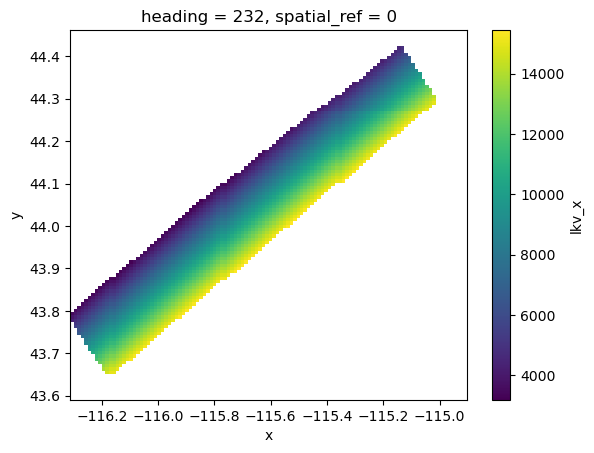

In [2]:
xr.open_dataset('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/geometry/uavsar_geom_v2.nc')['lkv_x'].sel(heading = '232').plot()